In this notebook, we visualise the data for both raw and normalised cases. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

No default features for kernel instance. Please specify features.


In [2]:
# Path_raw = '../../data/Results_Microplate_normFalse_formatSeq_logTrue.csv'
# Path_normalised = '../../data/Results_Microplate_normTrue_plateRep_formatSeq_logTrue.csv'

Path_raw = '../../data/Results_Microplate_partialFalse_normFalse_formatSeq_logTrue.csv'
Path_normalised = '../../data/Results_Microplate_partialFalse_normTrue_plateRep_formatSeq_logTrue.csv'

df_raw = pd.read_csv(Path_raw)
df_normalised = pd.read_csv(Path_normalised)

In [3]:
df_raw

,Unnamed: 0,Name,Group,Plate,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,First_Plate,TTTAAGAAGGAGATATACAT,AGGAGA,80.919700,52.402431,98.720440,61.622165,54.151485,45.499195,65.552569,18.514648
1,1,RBS_1by1_1,bps_noncore,First_Plate,CTTAAGAAGGAGATATACAT,AGGAGA,58.336880,40.072951,81.136200,42.042854,45.432032,41.005659,51.337763,14.673422
2,2,RBS_1by1_2,bps_noncore,First_Plate,GTTAAGAAGGAGATATACAT,AGGAGA,38.780700,28.831559,58.763330,24.487870,24.133637,25.596639,33.432289,12.378064
3,3,RBS_1by1_3,bps_noncore,First_Plate,ATTAAGAAGGAGATATACAT,AGGAGA,60.720820,43.093359,74.605290,38.641958,38.049577,31.608154,47.786526,14.992992
4,4,RBS_1by1_4,bps_noncore,First_Plate,TCTAAGAAGGAGATATACAT,AGGAGA,58.099540,45.913214,70.531620,44.352931,38.394865,43.641794,50.155661,10.883487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,265,RBS_BA_1658,bandit2,Third_Plate,TTTAAGAGCTAAGTATACAT,GCTAAG,18.032699,15.510597,19.025742,49.556048,55.543099,NaN,31.533637,17.301573
262,266,RBS_BA_1548,bandit2,Third_Plate,TTTAAGAGCGGAGTATACAT,GCGGAG,30.783891,29.832041,29.059445,63.605031,73.146660,NaN,45.285413,19.100997
263,267,RBS_BA_2887,bandit2,Third_Plate,TTTAAGACTCTACTATACAT,CTCTAC,16.428919,16.141052,13.846184,45.631922,53.535583,NaN,29.116732,16.920817
264,268,RBS_BA_3330,bandit2,Third_Plate,TTTAAGATGGTTATATACAT,TGGTTA,17.777483,17.799044,18.383063,46.936247,58.773355,NaN,31.933839,17.488569


In [4]:
df_normalised

,Unnamed: 0,Name,Group,Plate,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD,Pred Mean,Pred Std,Pred UCB
0,0,RBS_1by1_0,reference,First_Plate,TTTAAGAAGGAGATATACAT,AGGAGA,2.041126,2.180430,2.008687,2.651855,2.696232,1.759734,2.223011,0.375047,NaN,NaN,NaN
1,1,RBS_1by1_1,bps_noncore,First_Plate,CTTAAGAAGGAGATATACAT,AGGAGA,1.266224,1.401483,1.487751,1.504470,2.117809,1.479173,1.542818,0.295177,NaN,NaN,NaN
2,2,RBS_1by1_2,bps_noncore,First_Plate,GTTAAGAAGGAGATATACAT,AGGAGA,0.424247,0.569569,0.696390,0.191885,0.386420,0.371286,0.439966,0.174313,NaN,NaN,NaN
3,3,RBS_1by1_3,bps_noncore,First_Plate,ATTAAGAAGGAGATATACAT,AGGAGA,1.356465,1.603619,1.273798,1.275503,1.576387,0.834058,1.319972,0.278481,NaN,NaN,NaN
4,4,RBS_1by1_4,bps_noncore,First_Plate,TCTAAGAAGGAGATATACAT,AGGAGA,1.257113,1.785349,1.133755,1.654263,1.602915,1.645725,1.513187,0.256567,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,261,RBS_BA_1658,bandit2,Third_Plate,TTTAAGAGCTAAGTATACAT,GCTAAG,0.703687,0.322070,0.731291,0.909270,0.983769,NaN,0.730017,0.256728,0.677239,0.634139,1.945517
262,262,RBS_BA_1548,bandit2,Third_Plate,TTTAAGAGCGGAGTATACAT,GCGGAG,2.385545,2.142031,1.844362,1.410452,1.532289,NaN,1.862936,0.407869,0.789158,0.576882,1.942922
263,263,RBS_BA_2887,bandit2,Third_Plate,TTTAAGACTCTACTATACAT,CTCTAC,0.465162,0.412074,0.076381,0.754730,0.914710,NaN,0.524611,0.324900,0.813209,0.564510,1.942230
264,264,RBS_BA_3330,bandit2,Third_Plate,TTTAAGATGGTTATATACAT,TGGTTA,0.666195,0.643800,0.653379,0.806894,1.091817,NaN,0.772417,0.190526,0.706033,0.617109,1.940251


## AVERAGE Label Histogram

Text(0.5, 1.0, 'Normalised Average Label')

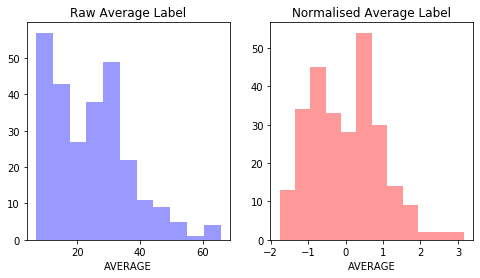

In [5]:
f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False)


sns.distplot(df_raw['AVERAGE'], kde=False, color="b", ax=axes[0])
axes[0].set_title('Raw Average Label')
sns.distplot(df_normalised['AVERAGE'], kde=False, color="r", ax=axes[1])
axes[1].set_title('Normalised Average Label')

## Replicates Distributions

Sorted by the average labels. x-axis represents sequences index with increasing average labels.

Text(0.5, 1.0, 'Normalised Replicates')

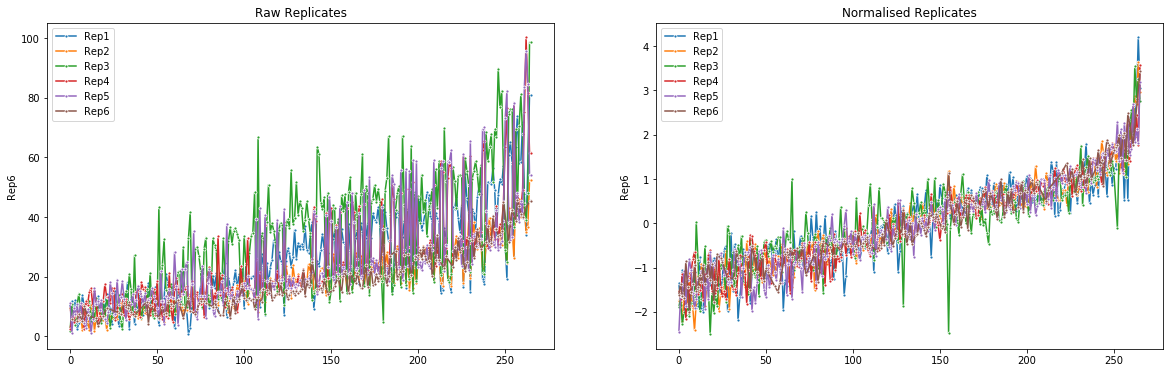

In [6]:
sorted_by_ave_df_raw = df_raw.sort_values(by = ['AVERAGE'])
sorted_by_ave_df_normalised = df_normalised.sort_values(by = ['AVERAGE'])

f, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

for i in ['Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5', 'Rep6']:
    sns.lineplot(range(len(sorted_by_ave_df_raw[i])), sorted_by_ave_df_raw[i], label = str(i), marker = '.', ax = axes[0])
    sns.lineplot(range(len(sorted_by_ave_df_normalised[i])), sorted_by_ave_df_normalised[i], label = str(i), marker = '.', ax = axes[1])
axes[0].set_title('Raw Replicates')
axes[1].set_title('Normalised Replicates')

Note the Z-score normalisation is in terms of each replicates, so if we sort each replicate and plot it, each replicates would like the similar, but note in this case, the x-axis does not represent the SAME sequence for each replicate.

Text(0.5, 1.0, 'Normalised Replicates, sorted by each replicate')

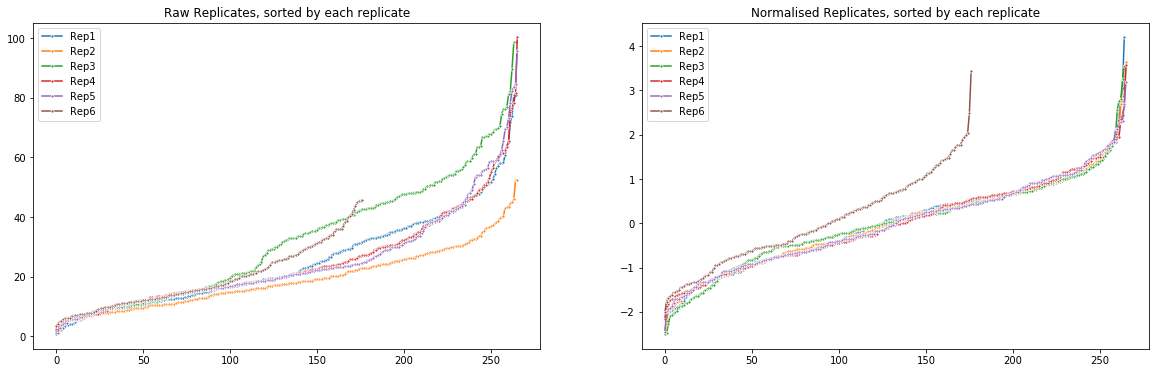

In [7]:
f, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

for i in ['Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5', 'Rep6']:
    sns.lineplot(range(len(df_raw[i])), np.sort(df_raw[i]), label = str(i), marker = '.', ax = axes[0])
    sns.lineplot(range(len(df_normalised[i])), np.sort(df_normalised[i]), label = str(i), marker = '.', ax = axes[1])
axes[0].set_title('Raw Replicates, sorted by each replicate')
axes[1].set_title('Normalised Replicates, sorted by each replicate')

## Violinplot

Text(0.5, 1.0, 'Normalised')

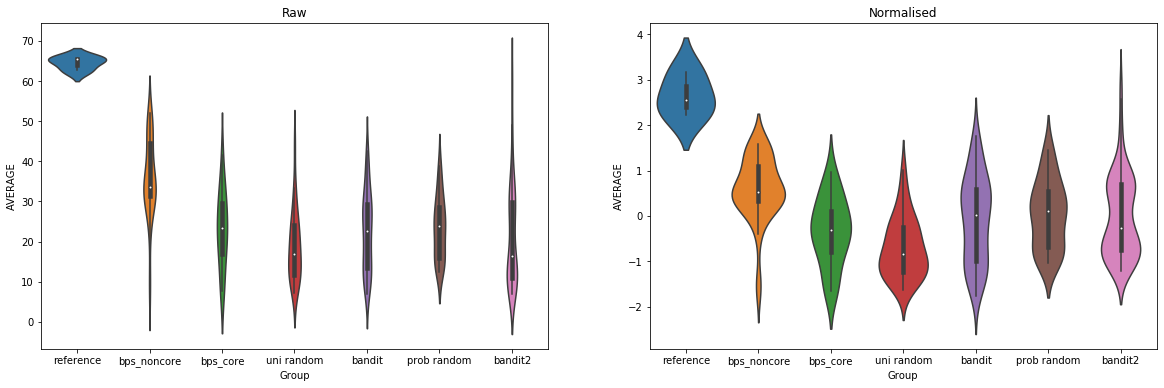

In [8]:
f, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

sns.violinplot(x = 'Group', y = 'AVERAGE', data = df_raw, ax = axes[0])
sns.violinplot(x = 'Group', y = 'AVERAGE', data = df_normalised, ax = axes[1])
axes[0].set_title('Raw')
axes[1].set_title('Normalised')

Text(0.5, 1.0, 'Normalised')

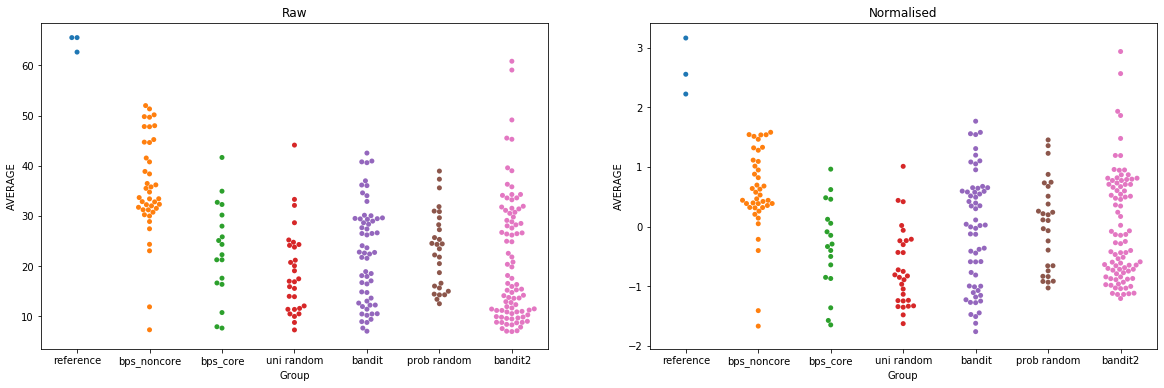

In [9]:
f, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_raw, ax = axes[0])
sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_normalised, ax = axes[1])
axes[0].set_title('Raw')
axes[1].set_title('Normalised')

In [10]:
## AVERAGE VS. Predictions

In [11]:
df_bandit2 = df_normalised[df_normalised['Group'] == 'bandit2']
df_bandit2

,Unnamed: 0,Name,Group,Plate,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD,Pred Mean,Pred Std,Pred UCB
177,177,RBS_BA_3385,bandit2,Third_Plate,TTTAAGATGCTATTATACAT,TGCTAT,0.873465,1.508608,1.406771,1.814858,1.787426,NaN,1.478226,0.381015,1.148037,0.751929,2.651895
178,178,RBS_BA_3387,bandit2,Third_Plate,TTTAAGATGCTGGTATACAT,TGCTGG,0.641533,1.470902,0.928522,1.470673,1.443031,NaN,1.190932,0.384347,0.993331,0.746657,2.486646
179,179,RBS_BA_1534,bandit2,Third_Plate,TTTAAGAGCGAATTATACAT,GCGAAT,0.864353,1.330124,0.976234,1.370671,1.422912,NaN,1.192859,0.254079,0.942982,0.769577,2.482136
180,180,RBS_BA_1896,bandit2,Third_Plate,TTTAAGAGTCTATTATACAT,GTCTAT,0.662496,0.741846,0.609019,1.236440,1.086846,NaN,0.867330,0.277875,1.000676,0.724696,2.450068
181,181,RBS_BA_2393,bandit2,Third_Plate,TTTAAGACGCTATTATACAT,CGCTAT,0.606408,0.428420,0.162147,0.992394,1.099876,NaN,0.657849,0.389972,1.022734,0.697815,2.418364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,260,RBS_BA_2084,bandit2,Third_Plate,TTTAAGACAGTGGTATACAT,CAGTGG,0.453887,0.628049,1.229068,1.312097,1.164601,NaN,0.957540,0.388762,0.558830,0.694957,1.948744
261,261,RBS_BA_1658,bandit2,Third_Plate,TTTAAGAGCTAAGTATACAT,GCTAAG,0.703687,0.322070,0.731291,0.909270,0.983769,NaN,0.730017,0.256728,0.677239,0.634139,1.945517
262,262,RBS_BA_1548,bandit2,Third_Plate,TTTAAGAGCGGAGTATACAT,GCGGAG,2.385545,2.142031,1.844362,1.410452,1.532289,NaN,1.862936,0.407869,0.789158,0.576882,1.942922
263,263,RBS_BA_2887,bandit2,Third_Plate,TTTAAGACTCTACTATACAT,CTCTAC,0.465162,0.412074,0.076381,0.754730,0.914710,NaN,0.524611,0.324900,0.813209,0.564510,1.942230


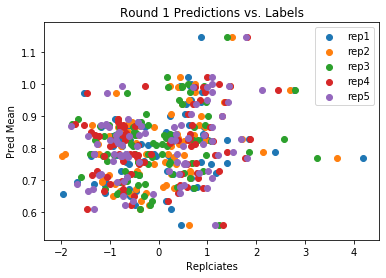

In [15]:
plt.scatter(df_bandit2['Rep1'], df_bandit2['Pred Mean'], label = 'rep1')
plt.scatter(df_bandit2['Rep2'], df_bandit2['Pred Mean'], label = 'rep2')
plt.scatter(df_bandit2['Rep3'], df_bandit2['Pred Mean'], label = 'rep3')
plt.scatter(df_bandit2['Rep4'], df_bandit2['Pred Mean'], label = 'rep4')
plt.scatter(df_bandit2['Rep5'], df_bandit2['Pred Mean'], label = 'rep5')
plt.xlabel('Replciates')
plt.ylabel('Pred Mean')
plt.title('Round 1 Predictions vs. Labels')
plt.legend()